In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

In [27]:
vaccinations = pd.read_csv("owid-covid-data.csv")
vaccinations['date'] = pd.to_datetime(vaccinations['date'], format='%Y-%m-%d')

regions = pd.read_csv("vaccinationAnalysis/all.csv")

tweets = pd.read_csv("vaccination_all_tweets.csv")
sentiments = pd.read_csv("covid-19_vaccine_tweets_with_sentiment.csv")
all_tweet_data = pd.merge(sentiments, tweets, left_on = 'tweet_id', right_on = 'id')
all_tweet_data.rename(columns={'label': 'sentiment'}, inplace=True)

print(vaccinations.head(), regions.head(), all_tweet_data.head())

  iso_code continent     location       date  total_cases  new_cases  \
0      AFG      Asia  Afghanistan 2020-02-24          1.0        1.0   
1      AFG      Asia  Afghanistan 2020-02-25          1.0        0.0   
2      AFG      Asia  Afghanistan 2020-02-26          1.0        0.0   
3      AFG      Asia  Afghanistan 2020-02-27          1.0        0.0   
4      AFG      Asia  Afghanistan 2020-02-28          1.0        0.0   

   new_cases_smoothed  total_deaths  new_deaths  new_deaths_smoothed  ...  \
0                 NaN           NaN         NaN                  NaN  ...   
1                 NaN           NaN         NaN                  NaN  ...   
2                 NaN           NaN         NaN                  NaN  ...   
3                 NaN           NaN         NaN                  NaN  ...   
4                 NaN           NaN         NaN                  NaN  ...   

   extreme_poverty  cardiovasc_death_rate  diabetes_prevalence  \
0              NaN                597.

In [28]:
vax_info = vaccinations[['iso_code', 'location', 'people_vaccinated_per_hundred', 'continent']]
region_info = regions[['name', 'alpha-2', 'alpha-3', 'country-code', 'region', 'region-code']]
tweet_info = all_tweet_data[['id', 'user_location', 'user_followers', 'sentiment']]


In [33]:
vax_n = region_info['name']
vax_a2 = region_info['alpha-2']
vax_a3 = region_info['alpha-3']
vax_r = region_info['region']
def fixlocation(loc):
    loc = str(loc).split(", ")
    hit = False
    for i in range(len(vax_n)):
        for l in loc:
            if l == str(vax_n[i]):
                return str(vax_n[i])
            elif l == str(vax_a2[i]):
                return str(vax_n[i])
            elif l == str(vax_a3[i]):
                return str(vax_n[i])
            elif l == str(vax_r[i]):
                return str(vax_n[i])
    return loc[-1]

def categorizeNum(val):
    if val == 1:
        return "negative"
    elif val == 2:
        return "neutral"
    elif val > 2:
        return "positive"
    else:
        return "unsure"

In [34]:
tweet_info = tweet_info.dropna(how='any',axis=0) 
tweet_info['location'] = [fixlocation(loc) for loc in tweet_info['user_location']]
tweet_info = pd.merge(tweet_info, region_info, left_on='location', right_on='name', how='inner')

In [18]:
print(tweet_info[:50])

                     id                  user_location  user_followers  \
0   1362165556091191296                 Wisconsin, USA            3744   
1   1384834947110903808            North Carolina, USA             534   
2   1359713613087469568                Des Moines, USA             269   
3   1355007738003255296                 Minnesota, USA              30   
4   1353930694267817984                    Oregon, USA              23   
5   1381742837474193408                  Maryland, USA             258   
6   1346571604088729600                            USA            1283   
7   1366427896525578240                      Ohio, USA            1832   
8   1367563642418458624            Virgin Islands, USA              16   
9   1368941492593647616                  New York, USA             456   
10  1383120250888081408                            USA             345   
11  1384962498936426496                   Arizona, USA             980   
12  1380254488808673280               

In [35]:

vaax_info = vax_info.groupby('location').aggregate({'iso_code': 'max', 'people_vaccinated_per_hundred': 'max', 
                                           'continent': 'max'})
print(vaax_info.head())

             iso_code  people_vaccinated_per_hundred continent
location                                                      
Afghanistan       AFG                           1.67      Asia
Africa       OWID_AFR                           2.62       NaN
Albania           ALB                          19.02    Europe
Algeria           DZA                           5.70    Africa
Andorra           AND                          50.04    Europe


In [36]:
tweet_vax =pd.merge(tweet_info, vaax_info, left_on='location', right_on=vaax_info.index, how="inner")
print(tweet_vax.head())

                    id                  user_location  user_followers  \
0  1381551830270889984  Mumbai, Delhi, Kolkata, India             338   
1  1366242037721223168                  Mumbai, India            7363   
2  1381467315162603520                          India              30   
3  1380777567112867840                          India         2088295   
4  1384993345835966464                          India             454   

   sentiment location name_x alpha-2_x alpha-3_x  country-code_x region_x  \
0          2    India  India        IN       IND             356     Asia   
1          2    India  India        IN       IND             356     Asia   
2          3    India  India        IN       IND             356     Asia   
3          3    India  India        IN       IND             356     Asia   
4          2    India  India        IN       IND             356     Asia   

   region-code_x name_y alpha-2_y alpha-3_y  country-code_y region_y  \
0          142.0  India   

In [37]:
tweet_vax['sentiment_val'] = [categorizeNum(val) for val in tweet_vax['sentiment']]

0.6678832116788321


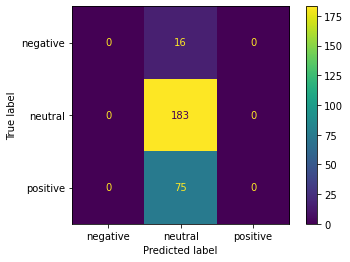

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt # just to format confusion matrix

# Write your code for question 4 here
# and store your results in the correct variable names for full credit

target = tweet_vax['sentiment_val']

data = tweet_vax[['country-code', 'people_vaccinated_per_hundred', 'user_followers']]

logistic_model = LogisticRegression()
logistic_model.fit(X=data, y=target)

tweet_vax['predicted_outcome'] = logistic_model.predict(data)

q4_score = logistic_model.score(data, target)

plot_confusion_matrix(logistic_model, data, target)

print(q4_score)

plt.grid(False)

In [64]:
res_neu = tweet_vax[tweet_vax['sentiment_val'] == 'neutral'] 
res_pos = tweet_vax[tweet_vax['sentiment_val'] == 'positive'] 
res_neg = tweet_vax[tweet_vax['sentiment_val'] == 'negative'] 
rslt_df = pd.concat([res_neu[:90], pd.concat([res_pos, res_neg])])
print(rslt_df)

                      id                  user_location  user_followers  \
0    1381551830270889984  Mumbai, Delhi, Kolkata, India             338   
1    1366242037721223168                  Mumbai, India            7363   
4    1384993345835966464                          India             454   
5    1384834144828477440               New Delhi, India            1314   
6    1343559031462518784             Maharashtra, India           23069   
..                   ...                            ...             ...   
158  1366991657221021696                      Hong Kong           19028   
170  1358637784836243456                       Zimbabwe             416   
184  1339371452110233600                       Malaysia          732148   
198  1377925756659982336               Lahore, Pakistan            7516   
268  1359566899600891904                         Uganda             565   

     sentiment   location     name_x alpha-2_x alpha-3_x  country-code_x  \
0            2      Ind

Model Score: 0.574585635359116


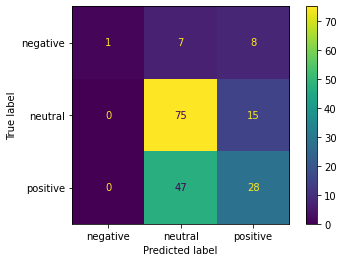

In [71]:

target = rslt_df['sentiment_val']

data = rslt_df[['people_vaccinated_per_hundred', 'user_followers', 'region-code_y']]

logistic_model = LogisticRegression()
logistic_model.fit(X=data, y=target)

rslt_df['predicted_outcome'] = logistic_model.predict(data)

q4_score = logistic_model.score(data, target)

plot_confusion_matrix(logistic_model, data, target)

print("Model Score:", q4_score)

plt.grid(False)